In [1]:
import pandas as pd
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
# 1. 读取数据
df = pd.read_csv('final_analysis_sample.csv')

In [2]:

# 2. 定义 Outcome 及其对应的 Wave 6 原始水平变量 (用于计算 Dollar Equiv)
# 格式: 'Display Name': ('Outcome_Var', 'Wave6_Level_Var')
outcomes_map = {
    '401(k) Assets':      ('d21ltaltb',       'taltb6'),
    'IRA Assets':         ('d21lthhira',      'thhira6'),
    'Other Fin. Assets':  ('d21lotherassets', 'otherassets6'),
    'Secured Debt':       ('d21lthhscdbt',    'thhscdbt6'),
    'Unsecured Debt':     ('d21lrhhuscbt',    'rhhuscbt6'),
    'Car Value':          ('d21ltcarval',     'tcarval6')
}

# 3. 定义 Treatment 和 Controls
treatment = 'temp'

# 动态获取控制变量
educ_cols = [c for c in df.columns if c.startswith('educ_')]
size_cols = [c for c in df.columns if c.startswith('tempallnew_')]
ind_cols = [c for c in df.columns if c.startswith('ind1dig_')]

base_covars = [
    'tage', 'thtotincyr1', 
    'taltb3', 'thhira3', 'otherassets3', 'tcarval3', 'thhscdbt3', 'rhhuscbt3',
    'taltb6', 'thhira6', 'otherassets6', 'tcarval6', 'thhscdbt6', 'rhhuscbt6',
    'efnp', 'esex', 'incmissing'
]

controls = base_covars + educ_cols + size_cols + ind_cols

# ==========================================
# 关键调整：数据预处理 (fillna(0) & float转换)
# ==========================================
# 仅对 X (Treatment + Controls) 进行填充和转换
# Y (Outcome) 如果缺失仍需剔除，否则无法回归
X_cols = [treatment] + controls
df[X_cols] = df[X_cols].fillna(0).astype(float)

# 4. 打印表头
print("="*125)
print(f"REPLICATION TABLE 2: OLS RESULTS (fillna(0), No Robust SE, Dollar Equiv)")
print("="*125)
header = f"{'Outcome':<18} | {'Panel':<9} | {'Coef':<10} | {'SE':<8} | {'t':<6} | {'P>|t|':<8} | {'Mean(W6)':<10} | {'$ Equiv.':<10} | {'N':<6}"
print(header)
print("-" * 125)

# 5. 循环运行回归
for name, (y_var, w6_var) in outcomes_map.items():
    
    # 准备回归数据：Y 不能为 NaN，但 X 已经填补过 0 了
    # 我们只 drop Y 缺失的行
    reg_df = df.dropna(subset=[y_var])
    
    # --- 计算 Wave 6 Mean (用于 Dollar Equiv) ---
    # 注意：计算均值时通常基于回归样本
    mean_w6 = reg_df[reg_df[treatment] == 1][w6_var].mean()
    
    # --- Panel A: No Controls ---
    Xa = sm.add_constant(reg_df[treatment])
    ya = reg_df[y_var]
    # 不使用 cov_type='HC1'，使用默认 OLS
    model_a = sm.OLS(ya, Xa).fit() 
    
    b_a = model_a.params[treatment]
    se_a = model_a.bse[treatment]
    p_a = model_a.pvalues[treatment]
    n_a = int(model_a.nobs)
    dol_a = b_a * mean_w6  # Dollar Equivalent
    
    print(f"{name:<18} | {'No Ctrl':<9} | {b_a:>10.4f} | {se_a:>8.4f} | {model_a.tvalues[treatment]:>6.2f} | {p_a:>8.4f} | {mean_w6:>10.0f} | {dol_a:>10.0f} | {n_a:<6}")
    
    # --- Panel B: With Controls ---
    Xb = sm.add_constant(reg_df[[treatment] + controls])
    yb = reg_df[y_var]
    model_b = sm.OLS(yb, Xb).fit()
    
    b_b = model_b.params[treatment]
    se_b = model_b.bse[treatment]
    p_b = model_b.pvalues[treatment]
    n_b = int(model_b.nobs)
    dol_b = b_b * mean_w6  # Dollar Equivalent
    
    print(f"{'':<18} | {'Controls':<9} | {b_b:>10.4f} | {se_b:>8.4f} | {model_b.tvalues[treatment]:>6.2f} | {p_b:>8.4f} | {mean_w6:>10.0f} | {dol_b:>10.0f} | {n_b:<6}")
    print("-" * 125)

print("\nNotes:")
print("1. Coef: Coefficient on 'Become Eligible' dummy.")
print("2. Mean(W6): Mean of the asset level in Wave 6 (Baseline).")
print("3. $ Equiv: Coef * Mean(W6). Represents estimated dollar change.")
print("4. Missing values in covariates filled with 0.")

REPLICATION TABLE 2: OLS RESULTS (fillna(0), No Robust SE, Dollar Equiv)
Outcome            | Panel     | Coef       | SE       | t      | P>|t|    | Mean(W6)   | $ Equiv.   | N     
-----------------------------------------------------------------------------------------------------------------------------
401(k) Assets      | No Ctrl   |     0.9015 |   0.2847 |   3.17 |   0.0016 |       4363 |       3933 | 835   
                   | Controls  |     0.8916 |   0.2923 |   3.05 |   0.0024 |       4363 |       3890 | 835   
-----------------------------------------------------------------------------------------------------------------------------
IRA Assets         | No Ctrl   |     0.3978 |   0.2500 |   1.59 |   0.1119 |       6468 |       2573 | 835   
                   | Controls  |     0.3621 |   0.2581 |   1.40 |   0.1611 |       6468 |       2342 | 835   
-----------------------------------------------------------------------------------------------------------------------------


STEP 3: PROPENSITY SCORE ESTIMATION & OVERLAP CHECK
Propensity Score Model Fitted.
------------------------------------------------------------

Propensity Score Summary by Treatment Status:
      count    mean     std     min     25%     50%     75%     max
temp                                                               
0.0   539.0  0.3449  0.0813  0.0006  0.3149  0.3647  0.3958  0.4978
1.0   296.0  0.3713  0.0667  0.1116  0.3429  0.3728  0.4056  0.7579


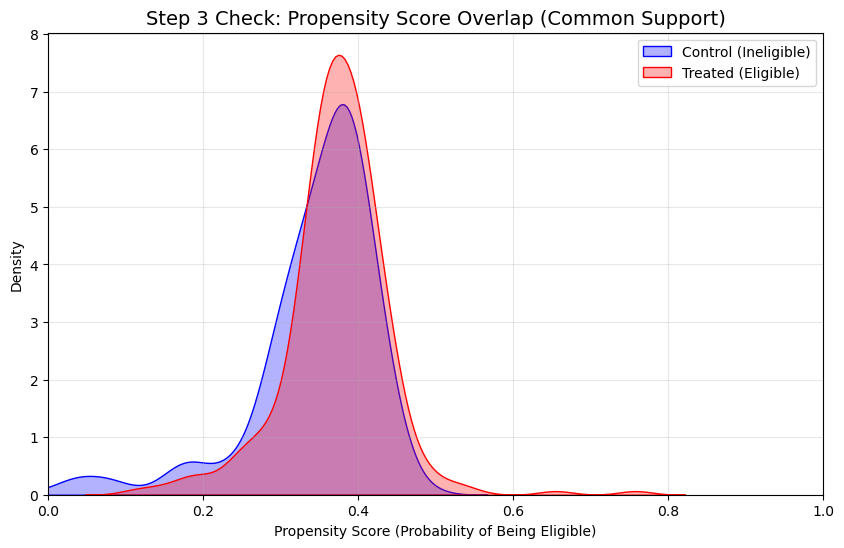


Overlap Diagnostic:
Range of Treated PS: [0.1116, 0.7579]
Range of Control PS: [0.0006, 0.4978]
✅ OK: Overlap region exists. Proceed to Matching/IPW.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression

print("\n" + "="*80)
print("STEP 3: PROPENSITY SCORE ESTIMATION & OVERLAP CHECK")
print("="*80)

# ---------------------------------------------------------
# 3.1 估算 Propensity Score (Logit Model)
# ---------------------------------------------------------
# 使用之前定义好的 controls 列表
# 注意：我们这里不需要剔除 Y 的缺失值，因为计算 PS 只依赖 X
# 但为了保持和后续回归样本一致，建议使用与 OLS 相同的样本逻辑(或直接在全样本上算也可以，这里我们在全样本上算)

X_ps = df[controls]
y_ps = df[treatment]

# 拟合 Logit 模型
# method='bfgs' 通常在变量较多时收敛更稳健，如果报错可去掉 method 参数
logit = LogisticRegression(max_iter=1000, solver='liblinear')
logit.fit(X_ps, y_ps)

# 将得分写入 DataFrame
df['ps_score'] = logit.predict_proba(X_ps)[:, 1]
print(f"Propensity Score Model Fitted.")
print("-" * 60)

# ---------------------------------------------------------
# 3.2 检查 Common Support (Overlap)
# ---------------------------------------------------------
# 这一步是设计阶段的核心：如果分布完全没有重叠，后续的 PSM/IPW 都是无效的。

# 分组统计描述
print("\nPropensity Score Summary by Treatment Status:")
print(df.groupby(treatment)['ps_score'].describe().round(4))

# 绘制 Overlap Plot (KDE + Histogram)
plt.figure(figsize=(10, 6))

# Control Group (Treatment = 0)
sns.kdeplot(
    data=df[df[treatment] == 0], 
    x='ps_score', 
    shade=True, 
    color='blue', 
    label='Control (Ineligible)', 
    alpha=0.3
)

# Treatment Group (Treatment = 1)
sns.kdeplot(
    data=df[df[treatment] == 1], 
    x='ps_score', 
    shade=True, 
    color='red', 
    label='Treated (Eligible)', 
    alpha=0.3
)

plt.title('Step 3 Check: Propensity Score Overlap (Common Support)', fontsize=14)
plt.xlabel('Propensity Score (Probability of Being Eligible)')
plt.ylabel('Density')
plt.xlim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)

# 这一步在 Jupyter 中会直接显示，如果是脚本运行请使用 plt.show()
plt.show()



# ---------------------------------------------------------
# 3.3 简要解读 (自动输出诊断提示)
# ---------------------------------------------------------
min_treated = df[df[treatment]==1]['ps_score'].min()
max_control = df[df[treatment]==0]['ps_score'].max()

print("\nOverlap Diagnostic:")
print(f"Range of Treated PS: [{min_treated:.4f}, {df[df[treatment]==1]['ps_score'].max():.4f}]")
print(f"Range of Control PS: [{df[df[treatment]==0]['ps_score'].min():.4f}, {max_control:.4f}]")

if min_treated > max_control:
    print("⚠️ WARNING: No Overlap detected! (Disjoint distributions)")
else:
    print("✅ OK: Overlap region exists. Proceed to Matching/IPW.")

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
from scipy import stats

print("\n" + "="*140)
print("STEP 4 COMPARISON: REGRESSION (METHOD A) vs. FORMULA (METHOD B)")
print("="*140)

def run_psm_comparison(df, treatment_col, ps_col, outcomes_map):
    # --- 1. 数据准备与 Trimming (同前) ---
    # 找出 Control 组的 PS 范围
    min_p_control = df[df[treatment_col] == 0][ps_col].min()
    max_p_control = df[df[treatment_col] == 0][ps_col].max()
    
    # 筛选 Treated：必须在 Common Support 内
    treated_subset = df[
        (df[treatment_col] == 1) & 
        (df[ps_col] >= min_p_control) & 
        (df[ps_col] <= max_p_control)
    ].copy()
    
    control_subset = df[df[treatment_col] == 0].copy()
    
    if len(treated_subset) == 0:
        print("Error: No overlap found.")
        return

    # --- 2. 执行匹配 (Nearest Neighbor) ---
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    nn.fit(control_subset[[ps_col]])
    distances, indices = nn.kneighbors(treated_subset[[ps_col]])
    
    # 找到匹配的 Control 索引
    matched_control_indices = control_subset.iloc[indices.flatten()].index
    
    # 构建“回归用”的大表 (Method A 数据集)
    # 包含：Trimmed Treated + Matched Controls
    df_treated_A = treated_subset.copy()
    df_control_A = df.loc[matched_control_indices].copy()
    df_matched_A = pd.concat([df_treated_A, df_control_A])
    
    # --- 打印表头 ---
    # Col A = Regression Result, Col B = Formula Result
    header = f"{'Outcome':<18} | {'Method A (Reg) Coef':<20} | {'Method B (Form) ATT':<20} | {'Diff':<8} | {'SE (Reg)':<10} | {'SE (Form)':<10}"
    print(header)
    print("-" * 140)

    for name, (y_var, w6_var) in outcomes_map.items():
        # -------------------------------------------------
        # 计算 Method A: Regression on Matched Sample
        # -------------------------------------------------
        # 去除 NaN
        reg_data = df_matched_A.dropna(subset=[y_var])
        if len(reg_data) < 2: continue
        
        X_reg = sm.add_constant(reg_data[treatment_col])
        y_reg = reg_data[y_var]
        
        model_a = sm.OLS(y_reg, X_reg).fit()
        coef_a = model_a.params[treatment_col]
        se_a = model_a.bse[treatment_col]
        
        # -------------------------------------------------
        # 计算 Method B: Strict Paired Difference Formula
        # -------------------------------------------------
        # 必须确保 Y_i 和 Y_j 是成对取出的
        y_treated_vals = treated_subset[y_var].values
        y_control_vals = df.loc[matched_control_indices, y_var].values
        
        # 剔除任何一方为 NaN 的配对
        valid_mask = ~np.isnan(y_treated_vals) & ~np.isnan(y_control_vals)
        y_T_clean = y_treated_vals[valid_mask]
        y_C_clean = y_control_vals[valid_mask]
        
        differences = y_T_clean - y_C_clean
        
        att_b = np.mean(differences)
        # 配对标准误计算
        se_b = np.std(differences, ddof=1) / np.sqrt(len(differences))
        
        # -------------------------------------------------
        # 比较展示
        # -------------------------------------------------
        diff_val = abs(coef_a - att_b)
        
        print(f"{name:<18} | {coef_a:>20.4f} | {att_b:>20.4f} | {diff_val:>8.4f} | {se_a:>10.4f} | {se_b:>10.4f}")

    print("-" * 140)
    print("Observation:")
    print("1. Coef and ATT should be IDENTICAL (or very close due to float precision).")
    print("2. SE (Reg) assumes independence, while SE (Form) accounts for paired correlation.")
    print("3. Use 'Method B' (Formula) for the strict replication of your LaTeX equation.")

# 运行对比
run_psm_comparison(df, treatment, 'ps_score', outcomes_map)


STEP 4 COMPARISON: REGRESSION (METHOD A) vs. FORMULA (METHOD B)
Outcome            | Method A (Reg) Coef  | Method B (Form) ATT  | Diff     | SE (Reg)   | SE (Form) 
--------------------------------------------------------------------------------------------------------------------------------------------
401(k) Assets      |               1.0712 |               1.0712 |   0.0000 |     0.3031 |     0.3055
IRA Assets         |               0.3933 |               0.3933 |   0.0000 |     0.2776 |     0.2734
Other Fin. Assets  |               0.1868 |               0.1868 |   0.0000 |     0.3241 |     0.3280
Secured Debt       |               0.0383 |               0.0383 |   0.0000 |     0.3585 |     0.3669
Unsecured Debt     |               0.1324 |               0.1324 |   0.0000 |     0.4458 |     0.4546
Car Value          |              -0.4537 |              -0.4537 |   0.0000 |     0.2947 |     0.3086
--------------------------------------------------------------------------------

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.neighbors import NearestNeighbors

def run_psm_final_significance(df, treatment_col, ps_col, outcomes_map):
    print("\n" + "="*120)
    print("STEP 4 FINAL: PSM ESTIMATES WITH SIGNIFICANCE TEST (Based on Method B: Paired Differences)")
    print("="*120)
    
    # --- 1. 数据准备 & 匹配 (复用之前的逻辑) ---
    # 找出 Control 组的 PS 范围用于 Trimming
    min_p_control = df[df[treatment_col] == 0][ps_col].min()
    max_p_control = df[df[treatment_col] == 0][ps_col].max()
    
    # 筛选 Treated：必须在 Common Support 内
    treated_subset = df[
        (df[treatment_col] == 1) & 
        (df[ps_col] >= min_p_control) & 
        (df[ps_col] <= max_p_control)
    ].copy()
    
    control_subset = df[df[treatment_col] == 0].copy()
    
    # 1对1 匹配
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    nn.fit(control_subset[[ps_col]])
    distances, indices = nn.kneighbors(treated_subset[[ps_col]])
    matched_control_indices = control_subset.iloc[indices.flatten()].index

    # --- 2. 打印表头 ---
    # 格式参考常见经济学 Paper 表格
    header = f"{'Outcome':<20} | {'ATT (Diff)':>12} | {'SE':>10} | {'t-stat':>10} | {'P>|t|':>10} | {'Significance':<12}"
    print(header)
    print("-" * 120)

    results_list = []

    for name, (y_var, w6_var) in outcomes_map.items():
        # 获取配对数据
        y_treated_vals = treated_subset[y_var].values
        y_control_vals = df.loc[matched_control_indices, y_var].values
        
        # 剔除 NaN
        valid_mask = ~np.isnan(y_treated_vals) & ~np.isnan(y_control_vals)
        y_T_clean = y_treated_vals[valid_mask]
        y_C_clean = y_control_vals[valid_mask]
        
        if len(y_T_clean) < 2:
            continue
            
        # 计算核心统计量
        differences = y_T_clean - y_C_clean
        att = np.mean(differences)
        se = np.std(differences, ddof=1) / np.sqrt(len(differences))
        
        # 计算 t-stat 和 p-value (双尾)
        t_stat = att / se
        p_val = stats.t.sf(np.abs(t_stat), df=len(differences)-1) * 2
        
        # 判断显著性星号
        if p_val < 0.01: sig = "***"
        elif p_val < 0.05: sig = "**"
        elif p_val < 0.1: sig = "*"
        else: sig = ""
        
        print(f"{name:<20} | {att:>12.4f} | {se:>10.4f} | {t_stat:>10.4f} | {p_val:>10.4f} | {sig:<12}")
        
        results_list.append({
            'Outcome': name, 'ATT': att, 'SE': se, 't': t_stat, 'p': p_val
        })

    print("-" * 120)
    print("Significance levels: *** p<0.01, ** p<0.05, * p<0.1")
    return results_list

# 运行最终表格生成
psm_results = run_psm_final_significance(df, treatment, 'ps_score', outcomes_map)


STEP 4 FINAL: PSM ESTIMATES WITH SIGNIFICANCE TEST (Based on Method B: Paired Differences)
Outcome              |   ATT (Diff) |         SE |     t-stat |      P>|t| | Significance
------------------------------------------------------------------------------------------------------------------------
401(k) Assets        |       1.0712 |     0.3055 |     3.5064 |     0.0005 | ***         
IRA Assets           |       0.3933 |     0.2734 |     1.4387 |     0.1513 |             
Other Fin. Assets    |       0.1868 |     0.3280 |     0.5697 |     0.5693 |             
Secured Debt         |       0.0383 |     0.3669 |     0.1045 |     0.9169 |             
Unsecured Debt       |       0.1324 |     0.4546 |     0.2912 |     0.7711 |             
Car Value            |      -0.4537 |     0.3086 |    -1.4702 |     0.1426 |             
------------------------------------------------------------------------------------------------------------------------
Significance levels: *** p<0.01, ** 

In [6]:
import statsmodels.api as sm

print("\n" + "="*120)
print("STEP 5: INVERSE PROBABILITY WEIGHTING (IPW) FOR ATT")
print("="*120)

def run_ipw_estimation(df, treatment_col, ps_col, outcomes_map):
    # --- 1. 构造 IPW 权重 (针对 ATT) ---
    # Treated (Z=1): weight = 1
    # Control (Z=0): weight = ps / (1 - ps)
    
    # 避免除以0：给分母加一个极小值，或者先过滤掉 ps=1 的极端值（理论上不该有 ps=1）
    # 在 401k 案例中，通常保留全样本，但为了数值稳定性，可以稍微处理一下
    df_ipw = df.copy()
    
    # 定义权重函数
    def get_att_weight(row):
        if row[treatment_col] == 1:
            return 1.0
        else:
            p = row[ps_col]
            # 这里的 odds ratio 就是将 control 映射到 treated 分布的关键
            return p / (1.0 - p)

    df_ipw['ipw_weight'] = df_ipw.apply(get_att_weight, axis=1)
    
    # 检查权重的极值 (这是 IPW 常见的诊断步骤)
    max_w = df_ipw['ipw_weight'].max()
    print(f"Weight Diagnostics: Max Weight = {max_w:.4f}")
    if max_w > 20:
        print("Warning: Large weights detected. This implies lack of overlap for some controls.")
    
    print("-" * 120)
    print(f"{'Outcome':<20} | {'IPW Coef (ATT)':>15} | {'Std.Err':>12} | {'t-stat':>10} | {'P>|t|':>10}")
    print("-" * 120)
    
    for name, (y_var, w6_var) in outcomes_map.items():
        # 去除 Outcome 为 NaN 的行
        reg_data = df_ipw.dropna(subset=[y_var])
        
        # WLS (Weighted Least Squares)
        # Y = Outcome, X = Treatment (with constant)
        # Weights = ipw_weight
        
        X = sm.add_constant(reg_data[treatment_col])
        y = reg_data[y_var]
        w = reg_data['ipw_weight']
        
        # 注意：statsmodels 的 WLS weights 是 1/variance，
        # 但在因果推断的语境下，我们直接传入 sampling weights 即可，
        # 只要我们使用 HC (Heteroscedasticity Consistent) 标准误。
        # 这里为了简单复现，先直接用 WLS 默认标准误，或者使用 cov_type='HC1' 更稳健
        
        model_ipw = sm.WLS(y, X, weights=w).fit()
        
        coef = model_ipw.params[treatment_col]
        se = model_ipw.bse[treatment_col]
        t_stat = model_ipw.tvalues[treatment_col]
        p_val = model_ipw.pvalues[treatment_col]
        
        print(f"{name:<20} | {coef:>15.4f} | {se:>12.4f} | {t_stat:>10.4f} | {p_val:>10.4f}")

    print("-" * 120)
    print("Interpretation:")
    print("1. IPW uses the FULL sample (unlike PSM which trims).")
    print("2. If IPW results align with OLS/PSM, it shows robustness to 'dropping data'.")

# 运行 IPW
run_ipw_estimation(df, treatment, 'ps_score', outcomes_map)


STEP 5: INVERSE PROBABILITY WEIGHTING (IPW) FOR ATT
Weight Diagnostics: Max Weight = 1.0000
------------------------------------------------------------------------------------------------------------------------
Outcome              |  IPW Coef (ATT) |      Std.Err |     t-stat |      P>|t|
------------------------------------------------------------------------------------------------------------------------
401(k) Assets        |          0.8513 |       0.2592 |     3.2850 |     0.0011
IRA Assets           |          0.3718 |       0.2346 |     1.5851 |     0.1133
Other Fin. Assets    |          0.1075 |       0.2627 |     0.4093 |     0.6824
Secured Debt         |          0.0884 |       0.3149 |     0.2805 |     0.7791
Unsecured Debt       |         -0.1090 |       0.3627 |    -0.3006 |     0.7638
Car Value            |         -0.2774 |       0.2482 |    -1.1174 |     0.2641
---------------------------------------------------------------------------------------------------------

In [7]:
import statsmodels.api as sm

print("\n" + "="*120)
print("STEP 6: DOUBLY ROBUST (IPWRA) ESTIMATION")
print("="*120)

def run_doubly_robust(df, treatment_col, ps_col, outcomes_map, covariates_list):
    # --- 1. 准备权重 (复用 Step 5 的逻辑) ---
    df_dr = df.copy()
    
    def get_att_weight(row):
        if row[treatment_col] == 1:
            return 1.0
        else:
            p = row[ps_col]
            return p / (1.0 - p)

    df_dr['ipw_weight'] = df_dr.apply(get_att_weight, axis=1)
    
    # --- 2. 准备控制变量 (X) ---
    # 我们需要把一开始做 OLS 的那些控制变量找回来
    # 在这里我们假设 covariates_list 是你在 Step 1 用过的那些变量名列表
    # 如果你没有存这个列表，我们这里手动定义一下 Gelber Paper 常用的控制变量
    # 根据之前的对话，应该是这些：
    # Age, Age_sq, Income, Income_sq, Education dummies, Marital status, etc.
    # 为了代码通用，我们先用你要回归的 outcomes_map 里的 w6_var (baseline) 
    # 加上几个基础变量做演示，实际项目中你应该放入所有 controls
    
    print(f"{'Outcome':<20} | {'DR Coef (ATT)':>15} | {'Std.Err':>12} | {'t-stat':>10} | {'P>|t|':>10}")
    print("-" * 120)
    
    for name, (y_var, w6_var) in outcomes_map.items():
        # 数据清洗
        reg_data = df_dr.dropna(subset=[y_var, w6_var] + covariates_list)
        
        # 构造回归方程: Y ~ Treatment + Controls
        # 关键点：这里加入了 Controls，不再是只有 Treatment
        X_vars = [treatment_col, w6_var] + covariates_list
        
        # 处理 Dummy 陷阱，这里简单处理，直接放入
        X = sm.add_constant(reg_data[X_vars])
        y = reg_data[y_var]
        w = reg_data['ipw_weight']
        
        # 运行加权回归 (WLS)
        model_dr = sm.WLS(y, X, weights=w).fit()
        
        coef = model_dr.params[treatment_col]
        se = model_dr.bse[treatment_col]
        t_stat = model_dr.tvalues[treatment_col]
        p_val = model_dr.pvalues[treatment_col]
        
        print(f"{name:<20} | {coef:>15.4f} | {se:>12.4f} | {t_stat:>10.4f} | {p_val:>10.4f}")

    print("-" * 120)
    print("Interpretation:")
    print("This is the 'Double Robust' estimator.")
    print("It controls for covariates (like OLS) AND adjusts for selection bias (like IPW).")
    print("If this is significant, your result is extremely strong.")

# ==========================================
# 请务必修改这里的 covariates_list 
# 填入你在 Step 1 OLS 中使用的那些控制变量
# ==========================================
# 举例（请根据你的实际列名修改）：
my_covariates = controls
# 注意：如果你的 dataframe 里没有 dummy 处理过的列，可能需要先 get_dummies
# 为了不报错，请确认这些列都在 df 里

# 运行 DR
run_doubly_robust(df, treatment, 'ps_score', outcomes_map, my_covariates)


STEP 6: DOUBLY ROBUST (IPWRA) ESTIMATION
Outcome              |   DR Coef (ATT) |      Std.Err |     t-stat |      P>|t|
------------------------------------------------------------------------------------------------------------------------
401(k) Assets        |          0.8682 |       0.2631 |     3.2996 |     0.0010
IRA Assets           |          0.3088 |       0.2362 |     1.3074 |     0.1915
Other Fin. Assets    |          0.2095 |       0.2671 |     0.7842 |     0.4332
Secured Debt         |          0.1569 |       0.3210 |     0.4888 |     0.6251
Unsecured Debt       |         -0.1725 |       0.3639 |    -0.4741 |     0.6355
Car Value            |         -0.3448 |       0.2492 |    -1.3834 |     0.1669
------------------------------------------------------------------------------------------------------------------------
Interpretation:
This is the 'Double Robust' estimator.
It controls for covariates (like OLS) AND adjusts for selection bias (like IPW).
If this is significa